# Building a Clustering Segmentation Model for Analyzing Worldwide Movie Revenue: Segmenting Market Performance to Target Specific Markets Based on Clustering Results

### Importing required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.cluster.hierarchy import linkage
from sklearn.metrics import pairwise_distances

### Loading dataset

In [13]:
segment_df = pd.read_csv("path_to_data.csv")
segment_df.head(2)

,Rank,Release Group,Worldwide,Domestic,Domestic_percent,Foreign,Foreign_percent,year
0,0,Toy Story 3,"1,06,69,69,703","41,50,04,880",38.90%,"65,19,64,823",61.10%,2010
1,1,Alice in Wonderland,"1,02,54,67,110","33,41,91,110",32.60%,"69,12,76,000",67.40%,2010


### Assessing the number of null values in the dataset

In [3]:
segment_df.isna().sum().sum()

0

### Removing commas , % from the numeric columns and convert to integers and floats

In [4]:
# converting to integers
segment_df['Worldwide']= segment_df['Worldwide'].astype(str).str.replace(',', '').astype(int)
segment_df['Domestic'] = segment_df['Domestic'].astype(str).str.replace(',', '').astype(int)
segment_df['Foreign'] = segment_df['Foreign'].astype(str).str.replace(',', '').astype(int)

# converting to floats
segment_df['Domestic_percent'] = segment_df['Domestic_percent'].astype(str).str.replace('%', '').astype(float)
segment_df['Foreign_percent'] = segment_df['Foreign_percent'].astype(str).str.replace('%', '').astype(float)


### Dropping unrequired and identifier columns

In [14]:
df_numeric = segment_df.drop(['Rank','Release Group','year'],axis =1)

### Defining custom gap_statistic function to determine number of clusters to be used.

In [6]:
def gap_statistic(X, n_refs=10, max_k=10):
    """ Compute Gap Statistic for a range of k values. """
    # Compute the within-cluster dispersion for each k
    def calculate_dispersion(X, k):
        clustering = AgglomerativeClustering(n_clusters=k)
        labels = clustering.fit_predict(X)
        return np.sum([np.sum(pairwise_distances(X[labels == i], X[labels == i])) for i in range(k)])
    
    def generate_reference_data(X, n_refs):
        """ Generate reference datasets and calculate dispersion """
        ref_dispersion = []
        for _ in range(n_refs):
            ref_data = np.random.random_sample(size=.shape)
            ref_dispersion.append([calculate_dispersion(ref_data, k) for k in range(1, max_k+1)])
        return np.array(ref_dispersion)
    
    # Compute dispersion for actual data

    # Generate reference data and compute dispersion
    ref_dispersion = generate_reference_data(X, n_refs)
    
    # Compute the gap statistic
    gap = np.mean(np.log(ref_dispersion), axis=0) - np.log(actual_dispersion)
    return gap


### Defining the pipeline for scaling and PCA

In [7]:
# Define the pipeline for scaling and PCA
pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('pca', PCA(n_components=min(df_numeric.shape[0], df_numeric.shape[1])))  
])

print("Analyzing the number of components generated\n")
print(pipeline)

# Fitting and transform the data with the pipeline
df_numeric_scaled_pca = pipeline.fit_transform(df_numeric)

# Extracting PCA results
pca = pipeline.named_steps['pca']
components = pca.components_
pc_list = [f'pca{i+1}' for i in range(pca.n_components_)]
pca_loadings = pd.DataFrame(components.T, index=df_numeric.columns, columns=pc_list)

print("\nPCA Loadings:")
pca_loadings


Analyzing the number of components generated

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=5))])

PCA Loadings:


,pca1,pca2,pca3,pca4,pca5
Worldwide,0.556438,0.223389,0.112757,0.011658,0.792227
Domestic,0.560452,0.050096,-0.771094,-0.004423,-0.297958
Domestic_percent,0.236299,-0.653796,0.129316,-0.707024,0.010383
Foreign,0.514403,0.304408,0.599403,-0.007755,-0.532336
Foreign_percent,-0.236267,0.653815,-0.129206,-0.707037,0.010382


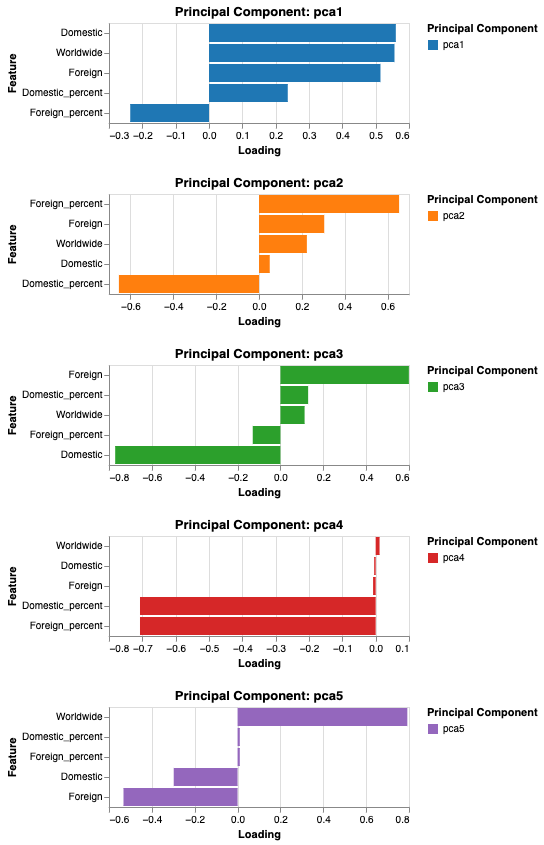

## Breakdown of Principal Components:
* #### contribution of the feature with the highest loadings*

* #### pca1: Worldwide and Domestic have the highest absolute values in pca1, which means these features have a significant impact on the first principal component.*
* #### pca2: Similarly, the feature with the highest loadings in pca2 is Domestic_percent, which means this feature has a substantial effect on the second principal component.*
* #### pca3: The feature Domestic has the highest negative loading in pca3, indicating it has a strong negative effect on this component.*
* #### pca4: Domestic_percent and Foreign_percent are significant for pca4.
* ### pca5: Worldwide and Foreign have high loadings in pca5.*

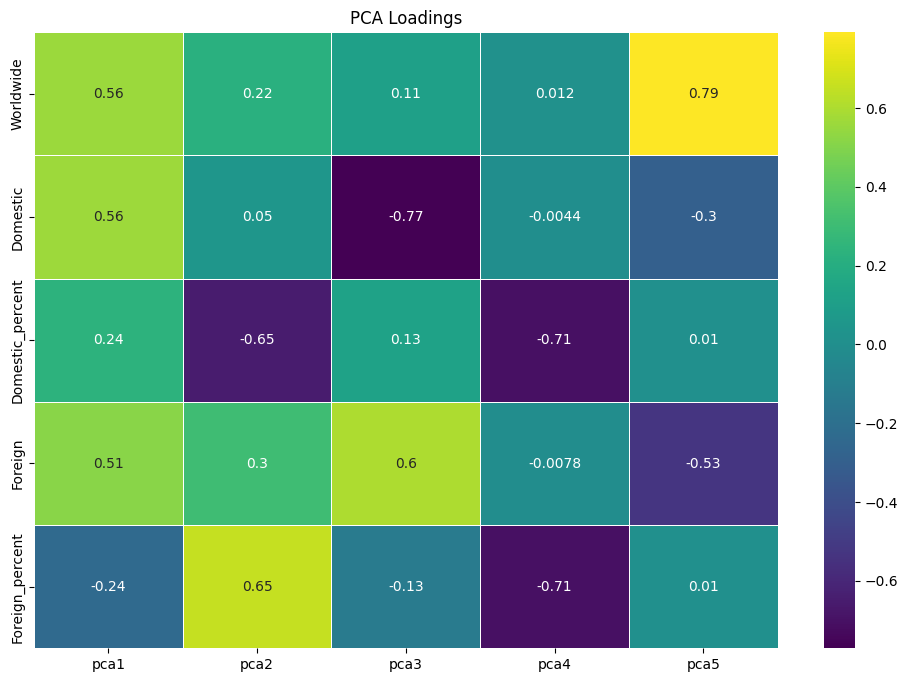

### Assessing the optimal number of clusters to be used using Gap Statistic plot

![Gap Statistic for Optimal Number of Clusters.png](<attachment:Gap Statistic for Optimal Number of Clusters.png>)
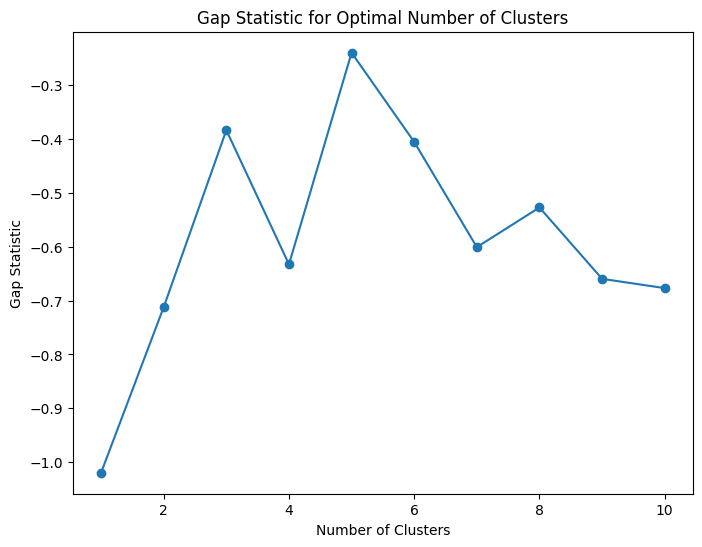

### # Determining the optimal number of clusters and applying the Agglomerative Clustering with the optimal number of clusters

In [9]:
# Determining the optimal number of clusters
print(f"Optimal number of clusters based on Gap Statistic: {optimal_k}")

# Applying the Agglomerative Clustering with the optimal number of clusters
clustering = AgglomerativeClustering(n_clusters=optimal_k)
segment_df['Cluster'] = clustering.fit_predict(df_numeric_scaled_pca)
#Displaying the Results
segment_df[['Release Group', 'Cluster']]

Optimal number of clusters based on Gap Statistic: 5


,Release Group,Cluster
0,Toy Story 3,1
1,Alice in Wonderland,1
2,Harry Potter and the Deathly Hallows: Part 1,1
3,Inception,0
4,Shrek Forever After,0
...,...,...
2795,On the Wandering Paths,3
2796,Weekend Rebels,3
2797,Ransomed,3
2798,Checker Tobi und die Reise zu den fliegenden F...,3


### Visualizing the clusters

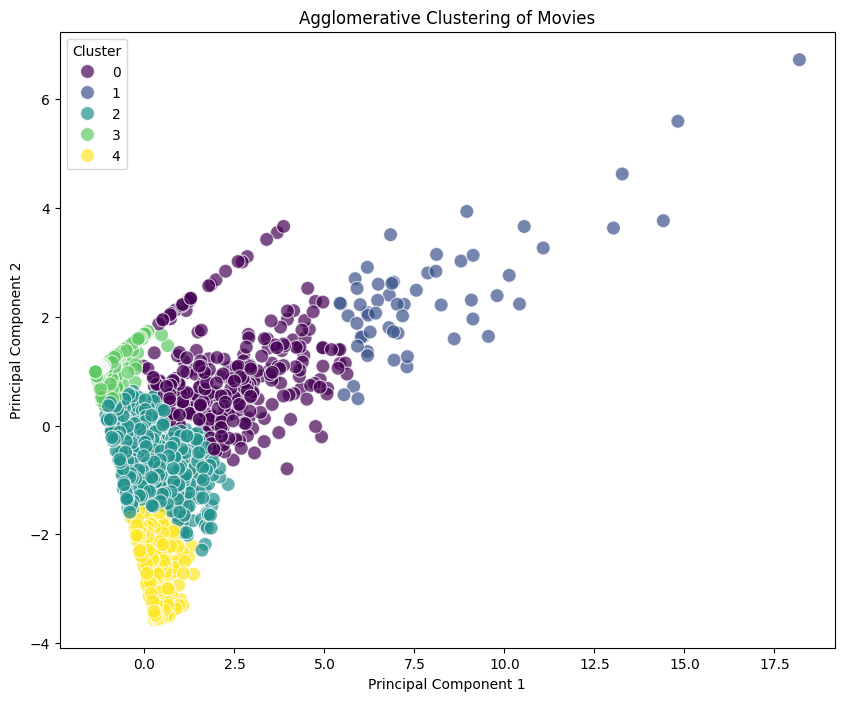

In [10]:

plt.figure(figsize=(10, 8))
sns.scatterplot(x=df_numeric_scaled_pca[:, 0], y=df_numeric_scaled_pca[:, 1], hue=segment_df['Cluster'], palette='viridis', s=100, alpha=0.7)
plt.title('Agglomerative Clustering of Movies')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

### Creating the dendrogram

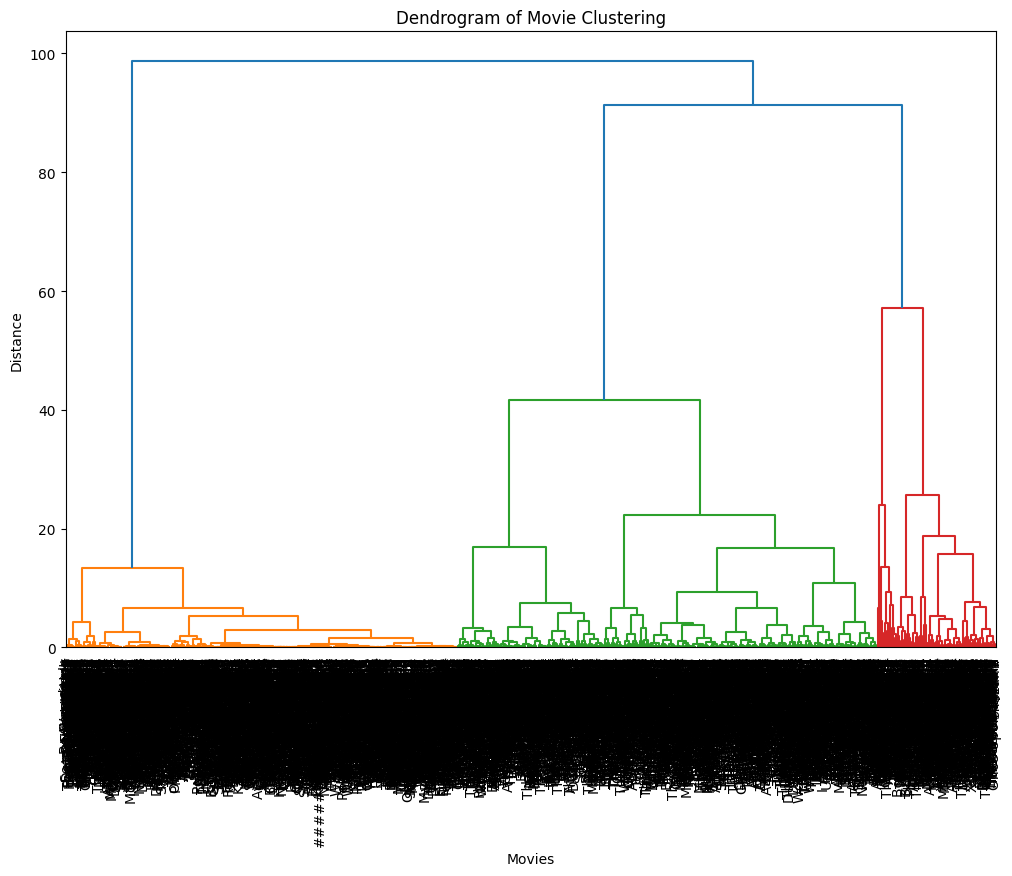

In [11]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Compute the linkage matrix
linkage_matrix = linkage(df_numeric_scaled_pca, method='ward')

# Truncate labels to a fixed length
truncated_labels = [label[:15] + '...' if len(label) > 15 else label for label in segment_df['Release Group']]

# Plot the dendrogram with truncated labels
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=truncated_labels, leaf_rotation=90, leaf_font_size=10)
plt.title('Dendrogram of Movie Clustering')
plt.xlabel('Movies')
plt.ylabel('Distance')
plt.show()


### Mean calculation of Cluaters

![Screenshot 2024-08-20 at 11.42.09 AM.png](<attachment:Screenshot 2024-08-20 at 11.42.09 AM.png>)



### Cluster Analysis Outcome
#### The output shows the mean values of various metrics (Rank, Worldwide, Domestic, Domestic_percent, Foreign, Foreign_percent, and year) for each cluster. 

### Interpret the results:
### Cluster 0:

##### Rank: 16.73, indicating movies in this cluster are generally highly ranked.
##### Worldwide: $476.56 million, suggesting moderate global box office revenue.
##### Domestic_percent: 29.98%, showing that these movies earn around 30% of their revenue domestically and 70% internationally.
##### Year: 2015.85, indicating that these movies are generally released around 2015.

### Cluster 1:

##### Rank: 2.21, indicating these movies are top-ranked (likely blockbuster hits).
##### Worldwide: $1.25 billion, showing very high global box office revenue.
##### Domestic_percent: 36.46%, suggesting a significant portion of their revenue comes from the domestic market, but the majority is still international (63.54%).
##### Year: 2016.56, indicating these movies are from around 2016.
##### Cluster 2:

##### Rank: 79.46, showing these movies are ranked lower on average.
##### Worldwide: $111.91 million, indicating lower global revenue.
##### Domestic_percent: 42.06%, suggesting a higher percentage of revenue comes from the domestic market compared to the other clusters.
##### Year: 2016.04, indicating these movies are from around 2016.

#### Cluster 3:

##### Rank: 130.42, indicating these movies are even lower-ranked.
##### Worldwide: $43.99 million, showing relatively low global revenue.
##### Domestic_percent: 0.94%, meaning these movies earn almost all their revenue internationally (99.05%).
##### Year: 2017.18, indicating these movies are from around 2017.

#### Cluster 4:

##### Rank: 122.65, indicating these movies are also lower-ranked.
##### Worldwide: $49.27 million, showing low global revenue.
##### Domestic_percent: 76.34%, meaning these movies earn the majority of their revenue domestically, with a smaller international share (23.66%).
##### Year: 2015.96, indicating these movies are from around 2015.

#### Conclusions:
##### Cluster 1 represents top-ranked, high-grossing blockbusters with a balanced domestic and international revenue distribution.
##### Cluster 2 consists of moderately successful movies with a higher domestic revenue share.
##### Cluster 0 includes moderately successful movies with a larger international audience.
##### Clusters 3 and 4 represent lower-ranked movies with low global revenue, with Cluster 3 focusing almost entirely on the international market and Cluster 4 on the domestic market.
##### This analysis can help target specific markets based on movie performance and clustering results, allowing for strategic marketing and distribution decisions.
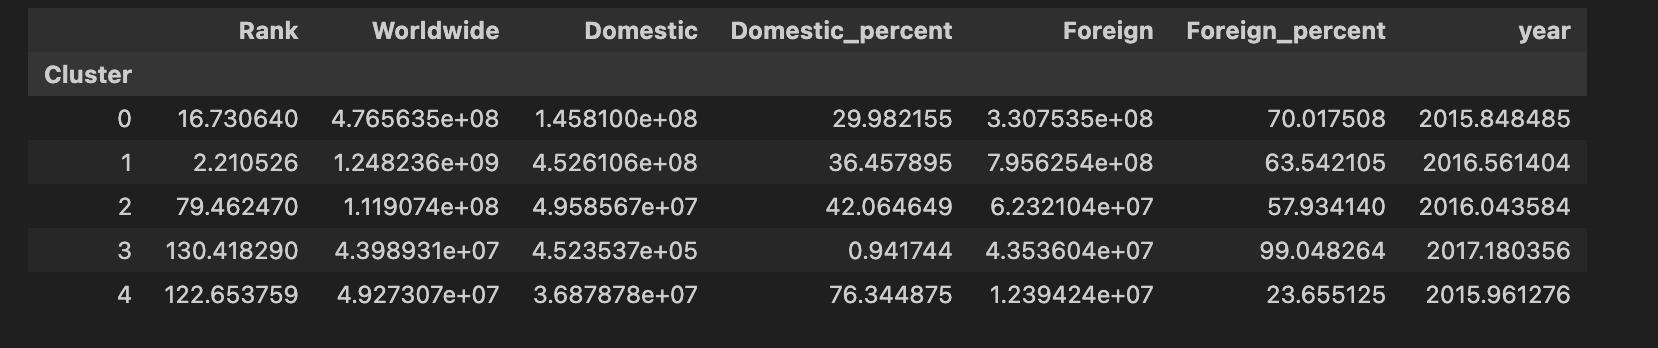